In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

###  Exploratory Analysis

We are going to check some variables and see what could be done

In [2]:
train_df = pd.read_csv("train.csv", index_col = "PassengerId")

In [3]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Checking for NaNs
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
# Evaluating balancing
train_df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
train_df["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [8]:
print("% of passengers in First class without cabin", train_df[train_df["Pclass"] == 1]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 1])*100)
print("% of passengers in Second class without cabin", train_df[train_df["Pclass"] == 2]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 2])*100)
print("% of passengers in Third class without cabin", train_df[train_df["Pclass"] == 3]["Cabin"].isna().sum() / len(train_df[train_df["Pclass"] == 3])*100)

% of passengers in First class without cabin 18.51851851851852
% of passengers in Second class without cabin 91.30434782608695
% of passengers in Third class without cabin 97.5560081466395


In [9]:
train_df.corr()
#sns.pairplot(train_df)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<AxesSubplot:>

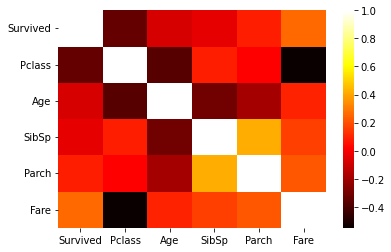

In [10]:
sns.heatmap(train_df.corr(), cmap="hot")

#### Conclusion

Input variables seem not linearly correlated with other input variables, neither with output variables. The only exception is PClass vs Fare which are negatively correlated (obviously lower classes relate with higher prices).

Sex Variable was cathegorized to be a 1/0 class.
Embarking location was ignored since it intuitively is not a predictor for survival rate. In further tests it could be added

Age is a variable containing NaNs, however it seems uncorrelated. Different methods will be tested to cover this problem

It was added a dummy variable "HasCabin" to check if a passenger has a cabin. It could be interesting to understand if passengers on cabin were more or less subject to survive. From exploratory analysis, cabin is correlated with class (first class passengers have more cabin wrt lower class passengers) but is seems that is a weak negative correlation between having a cabin and surviving. It could be a matter of chances, but an intuitive reason could be that people on cabin may reach outer areas in more time. Moreover, an additional variable based on "cabin zone": CabinLevel is created, based on the letter of the Deck on which are situated, such as expressed in: https://en.wikipedia.org/wiki/Titanic#Dimensions_and_layout. It is also possible to notices (as reported in resource linked) that A-cabins (lower levels) are linked with lower classes (1st class), however since "no level" was indicated with 0 in our dataset, there is a negative correlation between class and level.


About Target variable, there is some asymmetry between unsurvived and survived passengers, however dataset is not totally umbalanced.

## Preprocessing Functions

Here the set of functions (from above) to pre-process data


In [11]:
def add_cabin_level(df):
    # Checks for cabin letter and assign value based on area (cabin letter).
    # If cabin is NaN, assign 0, otherwise assign A=1, B=2 and so on
    
    array_level_name = np.zeros(len(df))
    for idx, val in enumerate(df["Cabin"].values):
        if val is not np.nan:
            array_level_name[idx] = ord(val[0]) - ord("A") +1

    df["CabinLevel"] = array_level_name
    return df



def add_has_cabin(df):
    # Sets 1 to any passenger with one or more cabins, 0 otherwise
    
    df["HasCabin"] = df["Cabin"].isna().astype("int")
    return df



def adjust_sex(df):
    # Assigns 1 to male sex, 0 otherwise
    
    df["Sex"] = pd.get_dummies(df, columns=["Sex"])["Sex_male"]
    return df


def fill_age_median(df):
    # Fill missing age values with median
    
    df["Age"] = df["Age"].fillna(value=df["Age"].median())
    return df


def filter_df(df, columns):
    # Return df with relevant columns
    
    return df[columns].copy()



def train_test_split(df, frac=0.8):
    # Train test split. Change frac only to train dataset for model validation.
    
    train = df.sample(frac=frac, random_state=1)
    test = df.drop(train.index)
    
    return train, test


def x_y_split(df):
    x = df.drop("Survived", axis=1)
    y = df["Survived"]
    
    return x, y


def setup_pipeline():
    columns = ["Sex", "Pclass", "Age", "SibSp", "Parch", "CabinLevel"]
    categorical_columns = ["Sex", "Pclass", "CabinLevel"]
    return columns, categorical_columns



def reduce_cardinality(all_names, base_names):
    # Reduce cardinality for onehot encoding
    
    drop_list = []
    
    for name in base_names:
        cur_list = [n for n in all_names if name in n]
        drop_list.append(cur_list[-1])
                
    return drop_list



def onehot_encoding(df, categorical_columns, OH_encoder, fit=False, df_train=None):
    # One Hot Encoding with fit or unfit features.
    # df is the only transformation df.
    # If Fit, requires a training dataset but not an encoder. Returns train_df, val_df, encoder
    # If not Fit, it requires the encoder but not the train_df. Returns only the encoded df
    
    
    if fit:
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        OH_encoder.fit(df_train[categorical_columns])
        colnames = OH_encoder.get_feature_names_out()
        drop_cols = reduce_cardinality(colnames, categorical_columns)
        OH_cols_train = pd.DataFrame(OH_encoder.transform(df_train[categorical_columns]), columns=colnames)
        OH_cols_train.index = df_train.index
        numeric_df_train = df_train.drop(categorical_columns, axis=1)
        OH_cols_train = OH_cols_train.drop(drop_cols, axis=1)
        new_df_train = pd.concat([numeric_df_train, OH_cols_train], axis=1)
        
    colnames = OH_encoder.get_feature_names_out()
    drop_cols = reduce_cardinality(colnames, categorical_columns)
    OH_cols = pd.DataFrame(OH_encoder.transform(df[categorical_columns]), columns=colnames)
    OH_cols.index = df.index
    numeric_df = df.drop(categorical_columns, axis=1)
    OH_cols = OH_cols.drop(drop_cols, axis=1)
    new_df = pd.concat([numeric_df, OH_cols], axis=1)
    
    if fit:
        return new_df_train, new_df, OH_encoder
    else:
        return new_df

    

def preprocessing_pipeline(df_input, columns, train=True):
    
    df = df_input.copy()
    
    
    if train:
        columns.append("Survived")
    df = adjust_sex(df)
    df = add_has_cabin(df)
    df = add_cabin_level(df)
    df = fill_age_median(df)
    filtered_df = filter_df(df, columns)
    
    return filtered_df


def train_test_onehot_preprocessing_pipeline(df_input):
    # Test with onehotencoder
    # Worse performances
    
    df = df_input.copy()
    columns, categorical_columns = setup_pipeline()
    
    filtered_df = preprocessing_pipeline(df, columns, train=True)
    
    train, test = train_test_split(filtered_df, frac=0.8)
    
    # HERE ONEHOT
    train, test, OH_encoder = onehot_encoding(test, categorical_columns, None, fit=True, df_train=train)
    x_train, y_train = x_y_split(train)
    x_val, y_val = x_y_split(test)
    
    return filtered_df, x_train, y_train, x_val, y_val, OH_encoder
    

def train_test_preprocessing_pipeline(df_input):
    
    df = df_input.copy()
    columns, categorical_columns = setup_pipeline()
    
    filtered_df = preprocessing_pipeline(df, columns, train=True)
    
    train, test = train_test_split(filtered_df, frac=0.8)
    
    # HERE ONEHOT
    x_train, y_train = x_y_split(train)
    x_val, y_val = x_y_split(test)
    
    return filtered_df, x_train, y_train, x_val, y_val



def test_preprocessing_pipeline(df_input, OH_encoder=None):
    
    df = df_input.copy()
    columns, categorical_columns = setup_pipeline()
    
    filtered_df = preprocessing_pipeline(df, columns, train=False)
    
   
    
    return filtered_df

## Inference and Utility Functions

In [12]:


def prettyprint_classification_report(report):
    
    report_mean = report["weighted avg"]
    print(f'Accuracy obtained: {report["accuracy"]}')
    print(f'Weighted Average precision: {report_mean["precision"]}')
    print(f'Weighted Average recall: {report_mean["recall"]}')
    print(f'Weighted Average f1 score: {report_mean["f1-score"]}')
    
    
def prettyprint_confusion_matrix(matrix):
    
    tp = matrix[0,0]
    tn = matrix[1,1]
    fp = matrix[0,1]
    fn = matrix[1,0]
    
    print("True Positives: ", tp)
    print("True Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    
    
def prediction_threshold_report(predictions_probability, threshold):
    
    test_prediction_max = np.maximum(predictions_probability[:,0], predictions_probability[:,1])
    prediction_over_threshold = test_prediction_max[test_prediction_max>=threshold]
    prediction_under_threshold = test_prediction_max[test_prediction_max<threshold]
    confident_prediction_ratio = len(prediction_over_threshold)/len(test_prediction_max)
    
    
    plt.hist(test_prediction_max, bins=50)
    plt.title("Distribution of prediction probability")
    plt.xlabel("Probability")
    plt.ylabel("Samples")
    plt.axvline(threshold, c="r", label="Confidence Threshold")
    plt.title(f"Prediction: confidence over threshold ratio: {confident_prediction_ratio}")
    plt.legend()
    
    
    

## First Test

A first test is trying to use data that has info about cabins and levels. For example it could be useful to check if "having a cabin" is a nice predictor of our algorithm.

Instead of using Fare, we will use Pclass. Instead of using CabinLevel, we will use HasCabin

About missing values, age will be replaced by median value

### Training

In [13]:
#new_df, x_train, y_train, x_test, y_test, OH_encoder = train_test_onehot_preprocessing_pipeline(train_df)
new_df, x_train, y_train, x_test, y_test = train_test_preprocessing_pipeline(train_df)

In [14]:
rf = RandomForestClassifier(n_estimators=100)

In [15]:
rf.fit(x_train, y_train)

RandomForestClassifier()

### Validation 

In [16]:
predictions = rf.predict(x_test)

In [17]:
report = classification_report(y_test.values, predictions, output_dict=True)
prettyprint_classification_report(report)

Accuracy obtained: 0.848314606741573
Weighted Average precision: 0.8477639179838762
Weighted Average recall: 0.848314606741573
Weighted Average f1 score: 0.8480105424751504


In [18]:
prettyprint_confusion_matrix(confusion_matrix(y_test.values, predictions))

True Positives:  104
True Negatives:  47
False Positives:  13
False Negatives:  14


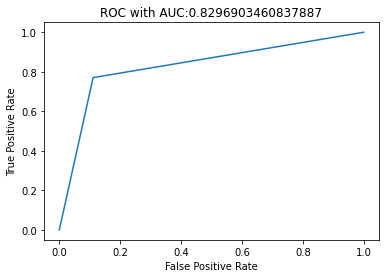

In [19]:
fpr, tpr, _ = roc_curve(y_test,  predictions)
auc = roc_auc_score(y_test,  predictions)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f"ROC with AUC:{auc}")
plt.show()

## Baseline models

Further validation is performed against two baseline models: using "none survived" baseline predictions and, then, using the "female sex" baseline predictor

In [20]:
dummy_predictions_1 = np.zeros(y_test.shape[0])
dummy_predictions_1.shape
dummy_report = classification_report(y_test.values, dummy_predictions_1, output_dict=True, zero_division=True)
prettyprint_classification_report(dummy_report)

Accuracy obtained: 0.6573033707865169
Weighted Average precision: 0.7747443504608005
Weighted Average recall: 0.6573033707865169
Weighted Average f1 score: 0.5213864025899829


In [21]:
# dummy_predictions_sex_female = x_test["Sex_0"] # Onehot Encoding
dummy_predictions_sex_female = np.abs(x_test["Sex"].values.astype("int16") -1)
report_sex_female = classification_report(y_test.values, dummy_predictions_sex_female, output_dict=True)
prettyprint_classification_report(report_sex_female)

Accuracy obtained: 0.8033707865168539
Weighted Average precision: 0.8013899651297947
Weighted Average recall: 0.8033707865168539
Weighted Average f1 score: 0.8021367557120985


### Explainable AI with Lime

In [22]:
import lime.lime_tabular
from lime.submodular_pick import SubmodularPick


In [23]:
"""
categorigal_names = OH_encoder.get_feature_names_out()
true_categorical_names = []
for name in x_train.columns:
    if name in categorigal_names:
        true_categorical_names.append(name)
""";

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns, class_names=[0, 1],  discretize_continuous=True)

In [51]:
i = np.random.randint(0, x_test.shape[0])
exp = explainer.explain_instance(x_test.iloc[i], rf.predict_proba, num_features=5, top_labels=1)
print(rf.predict_proba(x_test)[i], rf.predict(x_test)[i], y_test.iloc[i])
exp.show_in_notebook(show_table=True, show_all=True)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'iloc'

In [26]:
%%capture
sp_obj = SubmodularPick(explainer, x_train.values, rf.predict_proba, sample_size=100, num_features=len(x_train.columns), num_exps_desired=2);

#### Explainable AI insights:

- For class "Not survived":
   - Sex = 1 (Male) is high indicator of not surviving
   - Age > 34 is moderate indicator of not surviving
   - Cabin lvl = 0 (has no cabin) is indicator of not surviving
   - Third class passengers were more likely of not surviving
   - NOT Having a sibling/spouse negatively influence probability of death
   
- For class "Survived":
    - Sex = 0 (Female) is high indicator of surviving
    - First Class or Second Class passengers were more likely to survive
    - Passengers with cabins were unespectedly more likely to survive (coincides with higher class passgs)
    - Having sibling or spouse negatively influences survivability (again)
    - Age <= 22 is indicator of survivability
    
    
From this analysis, it seems that richier people, women and jounger people were more likely to survive

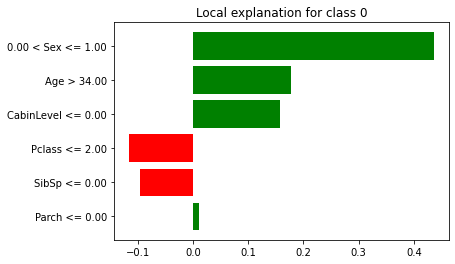

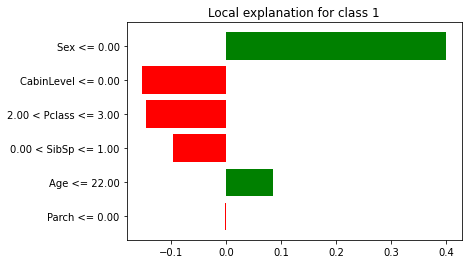

In [27]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];


## Kaggle Test Set Predictions

In [28]:
test_df = pd.read_csv("test.csv", index_col = "PassengerId")

In [29]:
filtered_test = test_preprocessing_pipeline(test_df)

In [30]:
filtered_test.head()

,Sex,Pclass,Age,SibSp,Parch,CabinLevel
PassengerId,,,,,,
892,1,3,34.5,0,0,0.0
893,0,3,47.0,1,0,0.0
894,1,2,62.0,0,0,0.0
895,1,3,27.0,0,0,0.0
896,0,3,22.0,1,1,0.0


In [31]:
test_predictions = rf.predict(filtered_test)

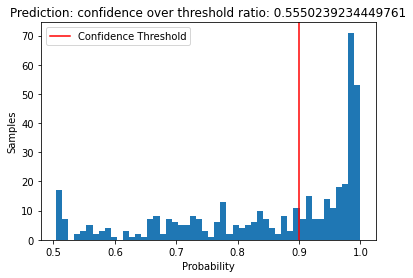

In [32]:
test_predictions_proba = rf.predict_proba(filtered_test)
prediction_threshold_report(test_predictions_proba, 0.9)

# Second Test

Using the same variables with another prediction method, i.e: xgboost

In [33]:
import xgboost as xgb

In [34]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=2)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=2, ...)

In [35]:
xgb_prediction = xgb_model.predict(x_test)

In [36]:
report = classification_report(y_test.values, xgb_prediction, output_dict=True)
prettyprint_classification_report(report)

Accuracy obtained: 0.8651685393258427
Weighted Average precision: 0.863826154670733
Weighted Average recall: 0.8651685393258427
Weighted Average f1 score: 0.8640162978160223


In [37]:
prettyprint_confusion_matrix(confusion_matrix(y_test.values, xgb_prediction))

True Positives:  107
True Negatives:  47
False Positives:  10
False Negatives:  14


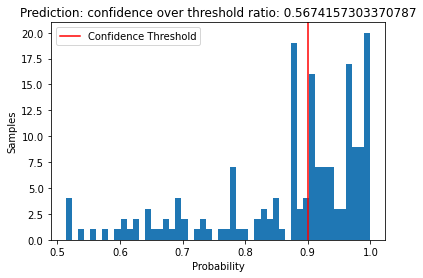

In [38]:
xgb_prediction_proba = xgb_model.predict_proba(x_test)
prediction_threshold_report(xgb_prediction_proba, 0.9)

### On Kaggle Test Set

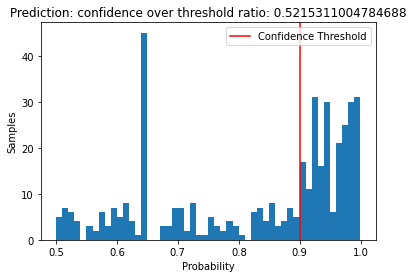

In [39]:
test_predictions = xgb_model.predict(filtered_test)
xgb_prediction_proba = xgb_model.predict_proba(filtered_test)
prediction_threshold_report(xgb_prediction_proba, 0.9)

In [40]:
test_prediction_max = np.maximum(xgb_prediction_proba[:,0], xgb_prediction_proba[:,1])
datas = np.c_[test_predictions, test_prediction_max]
results = pd.DataFrame(data = test_predictions, index=filtered_test.index, columns=["Survived"])
results

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,1
...,...
1305,1
1306,1
1307,0


In [41]:
#results.to_csv("submission_9.csv")

## Deep Learning Test

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.utils import plot_model


In [56]:
def PlotHistory(hist):
    '''
    Function to build the training curve plot
    '''
    
    fig, ax = plt.subplots(2, 1, figsize=(16,9))
    
    ax[0].plot(hist['loss'], label = "Training Loss")
    ax[0].plot(hist['val_loss'], label = "Validation Loss")
    ax[0].set_title("Training trend")
    ax[0].legend()
    
    ax[1].plot(hist['accuracy'], label = "Training Accuracy")
    ax[1].plot(hist['val_accuracy'], label = "Validation Accuracy")
    ax[1].set_title("Accuracy trend")
    ax[1].legend()
    
    
    plt.show()


In [57]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [58]:
# Early Stopping callback to stop training if validation loss does not decrease after 10 epochs
es = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 10,
    mode="auto",
    restore_best_weights=True
    )

# Max number of epochs and batch size parameters
epochs = 300

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               896       
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52,481
Trainable params: 52,481
Non-trai

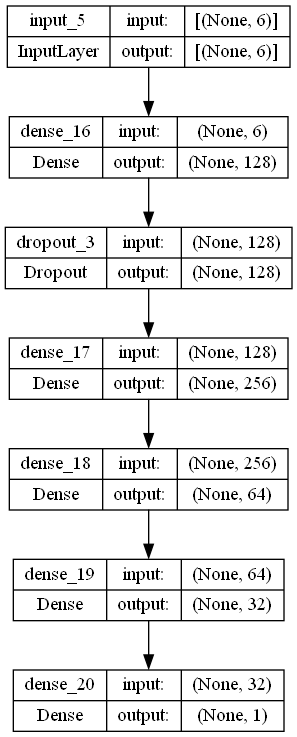

In [64]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1:])))
model.add(Dense(128, activation=LeakyReLU(alpha=0.01)))
model.add(Dropout(0.05))
model.add(Dense(256, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(64, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate = 3e-5), loss="binary_crossentropy", metrics=['accuracy'])

model.summary()
plot_model(model, show_shapes=True)

Epoch 1/300
45/45 [==============================] - 1s 5ms/step - loss: 0.6657 - accuracy: 0.6087 - val_loss: 0.6206 - val_accuracy: 0.6685
Epoch 2/300
45/45 [==============================] - 0s 2ms/step - loss: 0.6562 - accuracy: 0.6255 - val_loss: 0.6119 - val_accuracy: 0.6685
Epoch 3/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6311 - val_loss: 0.6046 - val_accuracy: 0.6685
Epoch 4/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6311 - val_loss: 0.5983 - val_accuracy: 0.6966
Epoch 5/300
45/45 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6213 - val_loss: 0.5899 - val_accuracy: 0.7022
Epoch 6/300
45/45 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6297 - val_loss: 0.5900 - val_accuracy: 0.7472
Epoch 7/300
45/45 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.6255 - val_loss: 0.5799 - val_accuracy: 0.7191
Epoch 8/300
4

Epoch 59/300
45/45 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.7265 - val_loss: 0.4454 - val_accuracy: 0.8034
Epoch 60/300
45/45 [==============================] - 0s 2ms/step - loss: 0.5433 - accuracy: 0.7377 - val_loss: 0.4431 - val_accuracy: 0.8090
Epoch 61/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5467 - accuracy: 0.7363 - val_loss: 0.4414 - val_accuracy: 0.8146
Epoch 62/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5440 - accuracy: 0.7335 - val_loss: 0.4408 - val_accuracy: 0.8202
Epoch 63/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5253 - accuracy: 0.7518 - val_loss: 0.4378 - val_accuracy: 0.8146
Epoch 64/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5242 - accuracy: 0.7419 - val_loss: 0.4499 - val_accuracy: 0.8202
Epoch 65/300
45/45 [==============================] - 0s 3ms/step - loss: 0.5309 - accuracy: 0.7447 - val_loss: 0.4385 - val_accuracy: 0.8258
Epoch 

45/45 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.7924 - val_loss: 0.3841 - val_accuracy: 0.8371
Epoch 117/300
45/45 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.7896 - val_loss: 0.3809 - val_accuracy: 0.8483
Epoch 118/300
45/45 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.7686 - val_loss: 0.3781 - val_accuracy: 0.8483
Epoch 119/300
45/45 [==============================] - 0s 3ms/step - loss: 0.4672 - accuracy: 0.7994 - val_loss: 0.3778 - val_accuracy: 0.8539
Epoch 120/300
45/45 [==============================] - 0s 2ms/step - loss: 0.4774 - accuracy: 0.7812 - val_loss: 0.3824 - val_accuracy: 0.8539
Epoch 121/300
45/45 [==============================] - 0s 3ms/step - loss: 0.4823 - accuracy: 0.7826 - val_loss: 0.3842 - val_accuracy: 0.8427
Epoch 122/300
45/45 [==============================] - 0s 3ms/step - loss: 0.4764 - accuracy: 0.7896 - val_loss: 0.3811 - val_accuracy: 0.8539
Epoch 123/300

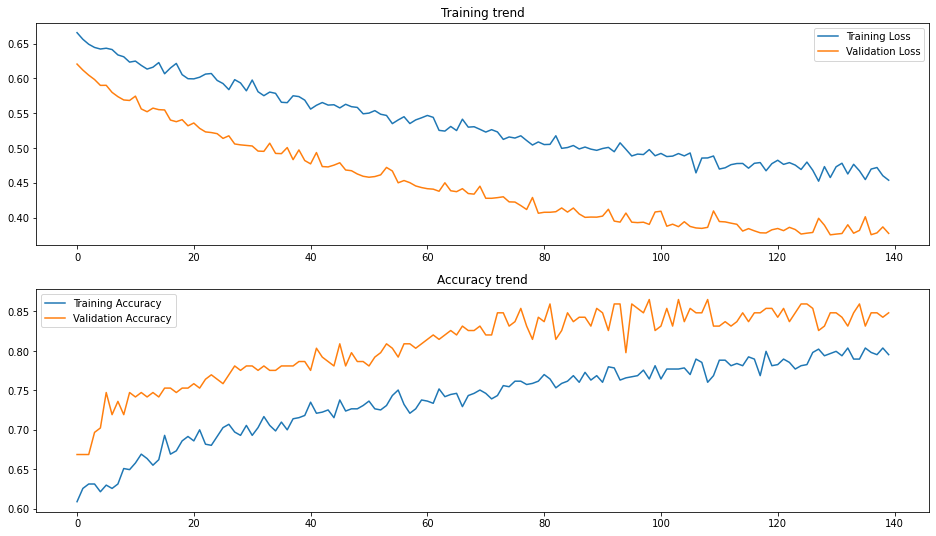

In [65]:
model_filename = f"./densenet.h5"

if not os.path.isfile(model_filename):
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = epochs, batch_size = 16, callbacks = [es], use_multiprocessing=True)
    PlotHistory(history.history)
    #model.save(model_filename)
else:
    history = []
    #model = load_model(model_filename)

In [66]:
predictions = model.predict(filtered_test)
threshold = 0.5
predictions = (predictions >= threshold).astype(int)

14/14 [==============================] - 0s 847us/step


In [67]:
results = pd.DataFrame(data = predictions, index=filtered_test.index, columns=["Survived"])
results

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [68]:
results.to_csv("submission_10.csv")